In [1]:
import os
import pandas as pd
import numpy as np
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/Bus-Capstone')
import ttools #homemade module
import gtfs #homemade module
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')
%matplotlib inline

In [2]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips('gtfs_subset/')
stops = gtfs.load_stops('gtfs_subset/')
stop_times, tz_sched = gtfs.load_stop_times('gtfs_subset/')
tcal = gtfs.TransitCalendar('gtfs_subset/')
print 'Finished loading GTFS data.'

Finished loading GTFS data.


# get the sample of parsed AVL data.
Clean MTA prefixes from trip_id

In [3]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('20150106_parsed.csv')

bustime.columns = ['vehicle_id','route','timestamp','lat','lon','trip_id','trip_date','shape_id',
                   'next_stop_id','est_arrival','dist_from_stop','stop_dist_on_trip','presentable_dist','response']
bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')
bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)

In [4]:
bustime.groupby(level=2).size()

trip_date
2015-01-05      58837
2015-01-06    1591750
2015-01-07         49
dtype: int64

In [5]:
# for demonstration, use a subset. Just get data for one trip-date.
tripDateLookup = "2015-01-06" # this is a non-holiday Monday
bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)
bustime.sort_index(inplace=True)
print 'Finished loading BusTime data and and slicing one day.'

Finished loading BusTime data and and slicing one day.


In [6]:
# make a separate column with just the hour, to show distribution without parsing numerically
# bustime['timestamp_hour'] = bustime['timestamp'].str[11:13]
# bustime.groupby('timestamp_hour').size()

## Compare list of trip_id between GTFS schedule and BusTime reported data.
First just compare the length of the lists.

In [7]:
# Filter the service_ids for those applicable to this date
# gtfs.TransitCalendar class now correctly adjusts for exception dates
active_services = tcal.get_service_ids('2015-01-06') 
# Load a sepate trips dataframe but use only one index level
trips_ = gtfs.load_trips('gtfs_subset/').reset_index().set_index(['service_id'])
# Generate list of all trip_ids that are scheduled for those service_ids
gtfs_trip_ids = trips_.loc[active_services]['trip_id'].unique()
# Generate list of all trip_ids in BusTime subset
bustime_trip_ids = bustime.index.get_level_values(1).unique()

In [8]:
len(gtfs_trip_ids)

54281

In [9]:
len(bustime_trip_ids)

39662

## There appears to be a big difference in the trip_id lists.
Return the non-matching trip_ids and describe a few things about those trips, based on the GTFS data.

In [10]:
# parse times into numeric
ts_parsed = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-01-06')

### Plot distribution of BusTime pings throughout the day.  Look for sudden dips (gaps).

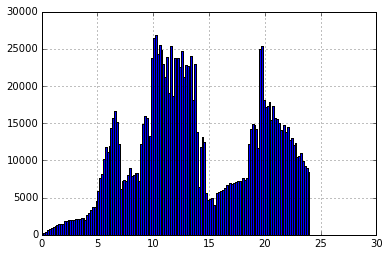

In [11]:
(ts_parsed/ttools.datetime.timedelta(hours=1)).hist(range=(0,30),bins=180)

There appears to major gaps in the mid-morning and mid-afternoon windows.
### Get the trip_id labels from GTFS which are not found anywhere in BusTime data

In [12]:
set1 = set(gtfs_trip_ids)
set2 = set(bustime_trip_ids)

unmatched = set1.symmetric_difference(set2) # goes both ways
len(unmatched)

14619

Show routes with percentage of trips missing any data

In [13]:
pct_missing_by_route = trips.loc[unmatched].groupby('route_id').size()/trips.groupby('route_id').size()
pct_missing_by_route.sort(ascending=False)
pct_missing_by_route

route_id
S86      0.500000
S81      0.333333
S84      0.312500
S94      0.294118
S90      0.277778
S91      0.260000
S98      0.257143
S96      0.232143
S56      0.209402
S92      0.187500
BX20     0.181818
X17A     0.167883
X11      0.163265
Q26      0.145038
S55      0.142857
X3       0.138889
S42      0.134328
X2       0.134146
X19      0.130435
S54      0.129518
X21      0.119048
M98      0.118280
S89      0.114865
Q77      0.113943
X4       0.113924
X68      0.111111
X17J     0.110132
S93      0.107042
X9       0.106870
X37      0.105691
           ...   
BXM6     0.009852
BM5      0.009804
Q25      0.009448
Q113     0.008830
BXM9     0.008287
QM1      0.007752
QM6      0.007435
QM24     0.007299
Q66      0.006024
Q21      0.005882
Q65      0.005410
QM20     0.004717
QM4      0.004016
Q53      0.003823
Q35      0.003371
BM4           NaN
BXM18         NaN
Q104          NaN
Q70           NaN
QM10          NaN
QM12          NaN
QM15          NaN
QM16          NaN
QM17          NaN
Q

### Show distribution of missing data according to the hour of service (based on stop times)
This should be roughly inverse to the data density plotted initially.

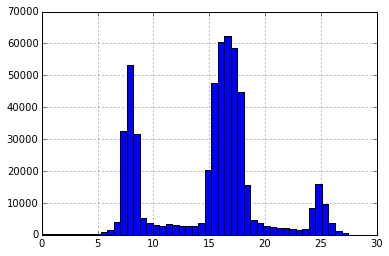

In [14]:
stop_hour = stop_times.reset_index().set_index('trip_id')['arrival_time'].apply(ttools.parseTime)/ttools.datetime.timedelta(hours=1)
stop_hour.loc[unmatched].hist(bins=48)

### Compare distributions of trip duration, all trips from GTFS versus the missing trips. 

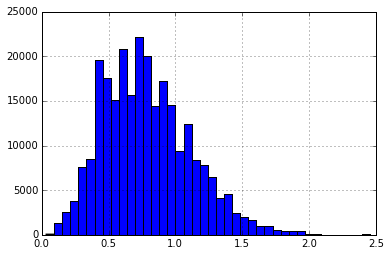

In [15]:
# Distribution of trip durations - ALL scheduled trips
pd.Series(stop_hour.groupby(level=0).max() - stop_hour.groupby(level=0).min()).hist(bins=40)

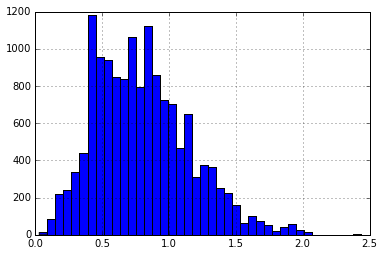

In [16]:
# Distribution of trip durations - MISSING trips only
pd.Series(stop_hour.loc[unmatched].groupby(level=0).max() - stop_hour.loc[unmatched].groupby(level=0).min()).hist(bins=40)

## Analyze expected trip data-density, but agnostic to trip_id
Plot a comparison (GTFS versus BusTime) of how many vehicles are on an active trip throughout the day.

In [17]:
start_bins = (10*stop_hour.loc[gtfs_trip_ids].groupby(level=0).min()).apply(np.floor).astype(int)
end_bins = (10*stop_hour.loc[gtfs_trip_ids].groupby(level=0).max()).apply(np.floor).astype(int)

In [18]:
# time is divided into bins of 0.1 hours (6 minutes)
# make a 2D binary matrix indicating when the trip is active during each time bin.
time_bin_matrix = np.zeros((len(start_bins),max(end_bins)+1))
counter = 0
for i,v_start in start_bins.iteritems():
    v_end = end_bins.loc[i]
    time_bin_matrix[counter,v_start:v_end] = 1
    counter += 1

Now do the same from the BusTime data.  Danger - vehicles may be recording data even when not on an active trip.

In [19]:
start_bins_bustime = (10*(ts_parsed.groupby(level=(1,3)).min()/ttools.datetime.timedelta(hours=1))).apply(np.floor).astype(int)
end_bins_bustime = (10*(ts_parsed.groupby(level=(1,3)).max()/ttools.datetime.timedelta(hours=1))).apply(np.floor).astype(int)
time_bin_matrix_bustime = np.zeros((len(start_bins_bustime),max(end_bins_bustime)+1))
counter = 0
for i,v_start in start_bins_bustime.iteritems():
    v_end = end_bins_bustime.loc[i]
    time_bin_matrix_bustime[counter,v_start:v_end] = 1
    counter += 1

### Plot the comparison.
Note that the BusTime data tracks the expected density nicely, except in two obvious periods.

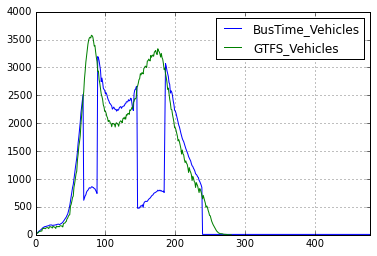

In [20]:
pd.DataFrame(time_bin_matrix_bustime.sum(axis=0),columns=['BusTime_Vehicles']).join(pd.Series(time_bin_matrix.sum(axis=0),name='GTFS_Vehicles')).plot()